### Data Storage Mechanism
Purpose: For ease of manual classification within each documents, based on the dates. Documents used in supervised learning models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime as dt
import os
import pickle
import codecs
import re
from tqdm import tqdm_notebook as tqdm

#For tokenizing sentences
import nltk
nltk.download('punkt')

plt.style.use('seaborn-whitegrid')

[nltk_data] Downloading package punkt to /Users/glenmond/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Read data from statement & minutes

In [2]:
file = open("../data/FOMC/statement.pickle", "rb")
st_df = pickle.load(file)

file = open("../data/FOMC/minutes.pickle", "rb")
mins_df = pickle.load(file)

### Preprocessing of Text
1. Clean Data
2. Normalization
    - Removing Stop words
    - Stemming and Lemmatization
3. Tokenization

In [3]:
mins_df.loc[150, 'contents']

'The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[SECTION]\n\nMonetary Policy Principles and Practice\n\n[SECTION]\n\nPolicy Implementation\n\n[SECTION]\n\nReports\n\n[SECTION]\n\nReview of Monetary Policy Strategy, Tools, and Communications\n\n[SECTION]\n\nInstitution Supervision\n\n[SECTION]\n\nReports\n\n[SECTION]\n\nReporting Forms\n\n[SECTION]\n\nSupervision & Regulation Letters\n\n[SECTION]\n\nBanking Applications & Legal Developments\n\n[SECTION]\n\nRegulatory Resources\n\n[SECTION]\n\nBanking & Data Structure\n\n[SECTION]\n\nRegulations & Statutes\n\n[SECTION]\n\nPayment Policies\n\n[SECTION]\n\nReserve Bank Payment Services & Data\n\n[SECTION]\n\nFinancial Market Utilities & Infrastructures\n\n[SECTION]\n\nResearch, Committees, and Forums\n\n[SECTION]\n\nWorking Papers and Notes\n\n[SECTION]\n\nModels and Tools\n\n[SECTION]\n\nBank A

In [4]:
# statements
# st_df['text'] = st_df['contents'].apply(lambda x: x.replace('\n\n[SECTION]\n\n', '').replace('\n', ' ').replace('\r', ' ').strip())
st_df['text'] = st_df['contents'].apply(lambda x: x.replace('\n', ' ').replace('\r', ' ').strip())
st_df.drop(columns=['title'], axis=1, inplace=True)

# minutes
# mins_df['text'] = mins_df['contents'].apply(lambda x: x.replace('\n\n[SECTION]\n\n', '').replace('\n', ' ').replace('\r', ' ').strip())
mins_df['text'] = mins_df['contents'].apply(lambda x: x.replace('\n', ' ').replace('\r', ' ').strip())
mins_df.drop(columns=['title'], axis=1, inplace=True)

In [5]:
print('Date: ', st_df.iloc[-1]['date'].strftime('%Y-%m-%d'))
print('Speaker: ', st_df.iloc[-1]['speaker'])
print('Text: \n\n', st_df.iloc[-1]['contents'].replace('\n[SECTION]\n', '')[1192:])

Date:  2021-09-22
Speaker:  Jerome Powell
Text: 

 
The Federal Reserve is committed to using its full range of tools to support the U.S. economy in this challenging time, thereby promoting its maximum employment and price stability goals.

With progress on vaccinations and strong policy support, indicators of economic activity and employment have continued to strengthen. The sectors most adversely affected by the pandemic have improved in recent months, but the rise in COVID-19 cases has slowed their recovery. Inflation is elevated, largely reflecting transitory factors. Overall financial conditions remain accommodative, in part reflecting policy measures to support the economy and the flow of credit to U.S. households and businesses.

The path of the economy continues to depend on the course of the virus. Progress on vaccinations will likely continue to reduce the effects of the public health crisis on the economy, but risks to the economic outlook remain.

The Committee seeks to ach

In [6]:
print('Date: ', mins_df.iloc[-1]['date'].strftime('%Y-%m-%d'))
print('Speaker: ', mins_df.iloc[-1]['speaker'])
print('Text: \n\n', mins_df.iloc[-1]['contents'].replace('\n[SECTION]\n', '')[1192:])

Date:  2021-07-28
Speaker:  Jerome Powell
Text: 

 l Reserve System was held by videoconference on Tuesday, July 27, 2021, at 9:00 a.m. and continued on Wednesday, July 28, 2021, at 9:00 a.m.1

PRESENT:

Jerome H. Powell, Chair
John C. Williams, Vice Chair
Thomas I. Barkin
Raphael W. Bostic
Michelle W. Bowman
Lael Brainard
Richard H. Clarida
Mary C. Daly
Charles L. Evans
Randal K. Quarles
Christopher J. Waller

James Bullard, Esther L. George, Naureen Hassan, Loretta J. Mester, and Eric Rosengren, Alternate Members of the Committee

Patrick Harker, Robert S. Kaplan, and Neel Kashkari, Presidents of the Federal Reserve Banks of Philadelphia, Dallas, and Minneapolis, respectively

James A. Clouse, Secretary
Matthew M. Luecke, Deputy Secretary
Michelle A. Smith, Assistant Secretary
Mark E. Van Der Weide, General Counsel
Michael Held, Deputy General Counsel
Trevor A. Reeve, Economist
Stacey Tevlin, Economist
Beth Anne Wilson, Economist

Shaghil Ahmed, Kartik B. Athreya, Brian M. Doyle, Roc

In [7]:
# CLEAN TEXT DATA

import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def clean_text(text):

    text = " " + text + " "
    text = text.replace("-"," ") # remove hyphen
    text = text.replace("\n"," ")
    text = text.replace('\n[SECTION]\n', '<stop>')
    text = text.replace('[SECTION]', '<stop>')
    text = text.replace('\r', '')
    text = text.replace("'s", "") # remove 's in python
    text = text.replace("[^a-zA-Z]+", " ") # remove any character that is not a-z OR A-Z
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    text = text.lower() # lower

    return text

def split_into_sentences(text):
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences] # remove whitespaces
    sentences = [re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', s) for s in sentences] # remove single letter string
    return sentences

### Clean the text content

In [8]:
# FOR LOOP FOR TO CLEAN THE DF OF CONTENTS 
st_df['contents'] = st_df['contents'].apply(lambda x : clean_text(x))
mins_df['contents'] = mins_df['contents'].apply(lambda x : clean_text(x))

### Remove stopwords & convert to sentences

In [9]:
from nltk.corpus import stopwords

excluded = ['no', 'not']
stop = stopwords.words('english')

# Remove stopwords
st_df['contentClean'] = st_df['contents'].apply(lambda x: " ".join(x for x in x.split() if (x not in stop) or (x in excluded)))
mins_df['contentClean'] = mins_df['contents'].apply(lambda x: " ".join(x for x in x.split() if (x not in stop) or (x in excluded)))

# Convert to sentences
st_df['sentences'] = st_df['contentClean'].apply(lambda x : split_into_sentences(x))
mins_df['sentences'] = mins_df['contentClean'].apply(lambda x : split_into_sentences(x))

# Convert intial contents to sentences without cleaning --> to aid classification of text to understand
st_df['original'] = st_df['contents'].apply(lambda x : split_into_sentences(x))
mins_df['original'] = mins_df['contents'].apply(lambda x : split_into_sentences(x))

### Filter Sentences with Important Key Words

In [10]:
### Filter sentences with keywords that affects central banks decision

import itertools

# Economic Growth
economic_growth = ['economic', 'economy', 'growth', 'slowdown', 'outlook']

# Employment Growth
employment_growth = ['labor', 'labour', 'unemployment', 'employment', 'job', 'staff', 'wage', 'employ']

# Inflation
inflation = ['price', 'prices', 'inflation', 'stagflation', 'disinflation', 'spending', 'spendings', 'cost', 'inflationary']

# # Policy Rate
# policy = ['fund', 'funds', 'rate', 'rates', 'risk', 'forecast']

# Combined Filter words
filter_words = list(itertools.chain(economic_growth, employment_growth, inflation))
filter_words

['economic',
 'economy',
 'growth',
 'slowdown',
 'outlook',
 'labor',
 'labour',
 'unemployment',
 'employment',
 'job',
 'staff',
 'wage',
 'employ',
 'price',
 'prices',
 'inflation',
 'stagflation',
 'disinflation',
 'spending',
 'spendings',
 'cost',
 'inflationary']

In [11]:
import string

# FOR MACHINE LEARNING CLASSIFICATION
def filter_relevant(sentences): # take in list sentence as input

    new_sentences = []
    
    for sentence in sentences:
        
        if any(s in sentence.lower() for s in filter_words):
            
            # remove punctuations
            sentence = ''.join([c for c in sentence if c not in string.punctuation])
            
            # remove numbers
            sentence = re.sub(r'[^a-zA-z.,!?/:;\"\'\s]','',sentence)
            
            # remove single letters
            sentence = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', sentence) # remove single letter string
            
            new_sentences.append(sentence)

    return new_sentences

# FOR DICTIONARY-BASED CLASSIFICATION
def remove_non_text(sentences): # take in list sentence as input

    new_sentences = []
    
    for sentence in sentences:
        
        # remove punctuations
        sentence = ''.join([c for c in sentence if c not in string.punctuation])

        # remove numbers
        sentence = re.sub(r'[^a-zA-z.,!?/:;\"\'\s]','',sentence)
        
        # remove single letters
        sentence = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', sentence) # remove single letter string

        if len(sentence) < 1: # means empty string
            continue
        
        else:
            new_sentences.append(sentence)

    return new_sentences

st_df['filterSentences'] = st_df['sentences'].apply(lambda x: filter_relevant(x))
st_df['filterSentencesDB'] = st_df['sentences'].apply(lambda x: remove_non_text(x)) # for dictionary-based

mins_df['filterSentences'] = mins_df['sentences'].apply(lambda x: filter_relevant(x))
mins_df['filterSentencesDB'] = mins_df['sentences'].apply(lambda x: remove_non_text(x)) # for dictionary-based

### Lemmatize the words within each sentences

In [12]:
# Lemmatization (Through each sentences list in the dataframe)
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_list(sentences):
    new_sentences = []
    
    for sentence in sentences:
        lemmatized_list = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]
        lemmatized_word = " ".join(lemmatized_list)
        new_sentences.append(lemmatized_word)

    return new_sentences

lemmatizer = WordNetLemmatizer()
# st_df['contentCleanLemmatized'] = st_df['contentClean'].apply(lambda x: [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(x)]).apply(lambda x:" ".join(x))


# FOR MACHINE LEARNING CLASSIFICATION
st_df['lemmatizedSentences'] = st_df['filterSentences'].apply(lambda x: lemmatize_list(x))
mins_df['lemmatizedSentences'] = mins_df['filterSentences'].apply(lambda x: lemmatize_list(x))

# FOR DICTIONARY-BASED METHOD
st_df['lemmatizedSentencesDB'] = st_df['filterSentencesDB'].apply(lambda x: lemmatize_list(x))
mins_df['lemmatizedSentencesDB'] = mins_df['filterSentencesDB'].apply(lambda x: lemmatize_list(x))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/glenmond/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/glenmond/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Storing Files in Different Folders

In [13]:
### STORING INTO DIFFERENT FOLDERS
from datetime import datetime

# FOR MACHINE LEARNING CLASSIFICATION
# Statements
for index, row in st_df.iterrows():
    df = pd.DataFrame(row['lemmatizedSentences'], columns=['Corpus'])
    df['Date'] = row['date'].strftime("%Y-%m-%d")
    df['Class'] = 0 # Hawkish = +1, Dovish=-1
    df['Original'] = row['filterSentences']
    date_details = row['date'].strftime("%Y-%m-%d")
    df = df[['Date', 'Original', 'Corpus', 'Class']]
    
    # load back to csv files
    df.to_csv(f"statement/{date_details}_corpus.csv")

# Minutes
for index, row in mins_df.iterrows():
    df = pd.DataFrame(row['lemmatizedSentences'], columns=['Corpus'])
    df['Date'] = row['date'].strftime("%Y-%m-%d")
    df['Class'] = 0 # Hawkish = +1, Dovish=-1
    df['Original'] = row['filterSentences']
    date_details = row['date'].strftime("%Y-%m-%d")
    df = df[['Date','Original', 'Corpus', 'Class']]
    
    # load back to csv files
    df.to_csv(f"minutes/{date_details}_corpus.csv")
    
    
# FOR DICTIONARY-BASED METHOD
# Statements
for index, row in st_df.iterrows():
    df = pd.DataFrame(row['lemmatizedSentencesDB'], columns=['Corpus'])
    df['Date'] = row['date'].strftime("%Y-%m-%d")
    df['Class'] = 0 # Hawkish = +1, Dovish=-1
    df['Original'] = row['filterSentencesDB']
    date_details = row['date'].strftime("%Y-%m-%d")
    df = df[['Date', 'Original', 'Corpus', 'Class']]
    
    # load back to csv files
    df.to_csv(f"statement/db/{date_details}_corpus.csv")

# Minutes
for index, row in mins_df.iterrows():
    df = pd.DataFrame(row['lemmatizedSentencesDB'], columns=['Corpus'])
    df['Date'] = row['date'].strftime("%Y-%m-%d")
    df['Class'] = 0 # Hawkish = +1, Dovish=-1
    df['Original'] = row['filterSentencesDB']
    date_details = row['date'].strftime("%Y-%m-%d")
    df = df[['Date','Original', 'Corpus', 'Class']]
    
    # load back to csv files
    df.to_csv(f"minutes/db/{date_details}_corpus.csv")

In [14]:
st_df

,date,contents,speaker,text,contentClean,sentences,original,filterSentences,filterSentencesDB,lemmatizedSentences,lemmatizedSentencesDB
0,2000-02-02,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open...,[committee remains concerned time increases de...,[immediate release federal open market committ...,[committee remains concerned time increase dem...,[immediate release federal open market committ...
1,2000-03-21,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open...,[economic conditions considerations addressed ...,[immediate release federal open market committ...,[economic condition consideration address comm...,[immediate release federal open market committ...
2,2000-05-16,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open...,[committee concerned disparity growth demand p...,[immediate release federal open market committ...,[committee concerned disparity growth demand p...,[immediate release federal open market committ...
3,2000-06-28,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open...,[recent data suggest expansion aggregate deman...,[immediate release federal open market committ...,[recent data suggest expansion aggregate deman...,[immediate release federal open market committ...
4,2000-08-22,for immediate release \tthe federal op...,Alan Greenspan,For immediate release \tThe Federal Op...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release \tthe federal op...,[recent data indicated expansion aggregate dem...,[immediate release federal open market committ...,[recent data indicate expansion aggregate dema...,[immediate release federal open market committ...
...,...,...,...,...,...,...,...,...,...,...,...
183,2021-03-17,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[federal reserve committed using full range to...,[federal reserve central bank united states pr...,[federal reserve commit use full range tool su...,[federal reserve central bank united state pro...
184,2021-04-28,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[federal reserve committed using full range to...,[federal reserve central bank united states pr...,[federal reserve commit use full range tool su...,[federal reserve central bank united state pro...
185,2021-06-16,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[federal reserve committed using full range to...,[federal reserve central bank united states pr...,[federal reserve commit use full range tool su...,[federal reserve central bank united state pro...
186,2021-07-28,"the federal reserve, the central bank of the ...",Jerome Powe

In [15]:
mins_df

,date,contents,speaker,text,contentClean,sentences,original,filterSentences,filterSentencesDB,lemmatizedSentences,lemmatizedSentencesDB
0,2000-02-02,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[meeting of the federal open market committee ...,[buy sells government securities including sec...,[meeting federal open market committee held of...,[buy sell government security include security...,[meeting federal open market committee held of...
1,2000-03-21,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[meeting of the federal open market committee ...,[pending completion study committee considerat...,[meeting federal open market committee held of...,[pending completion study committee considerat...,[meeting federal open market committee held of...
2,2000-05-16,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[meeting of the federal open market committee ...,[committee turned discussion economic financia...,[meeting federal open market committee held of...,[committee turn discussion economic financial ...,[meeting federal open market committee held of...
3,2000-06-28,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[meeting of the federal open market committee ...,[committee turned discussion economic outlook ...,[meeting federal open market committee held of...,[committee turn discussion economic outlook im...,[meeting federal open market committee held of...
4,2000-08-22,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[meeting of the federal open market committee ...,[committee turned discussion economic outlook ...,[meeting federal open market committee held of...,[committee turn discussion economic outlook im...,[meeting federal open market committee held of...
...,...,...,...,...,...,...,...,...,...,...,...
174,2021-01-27,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[mark carlson senior economic project manager ...,[federal reserve central bank united states pr...,[mark carlson senior economic project manager ...,[federal reserve central bank united state pro...
175,2021-03-17,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[mark carlson senior economic project manager ...,[federal reserve central bank united states pr...,[mark carlson senior economic project manager ...,[federal reserve central bank united state pro...
176,2021-04-28,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[mark carlson senior economic project manager ...,[federal reserve central bank united states pr...,[mark carlson senior economic project manager ...,[federal reserve 

### Data Exploration
Conduct data visualisation for statements and minutes

In [16]:
def concat_list(series):
    
    """Concat list of strings into one string"""
    
    all_words = ''
    for s in series.iteritems():
        words = ' '.join(s[1])
        all_words = all_words + words

    return all_words

# FOR MACHINE LEARNING CLASSIFICATION
st_words = concat_list(st_df['lemmatizedSentences'])
mins_words = concat_list(mins_df['lemmatizedSentences'])

# FOR DICTIONARY-BASED METHOD
st_words_db = concat_list(st_df['lemmatizedSentencesDB'])
mins_words_db = concat_list(mins_df['lemmatizedSentencesDB'])

#### Word Cloud
Word cloud visualisation for both statements and minutes

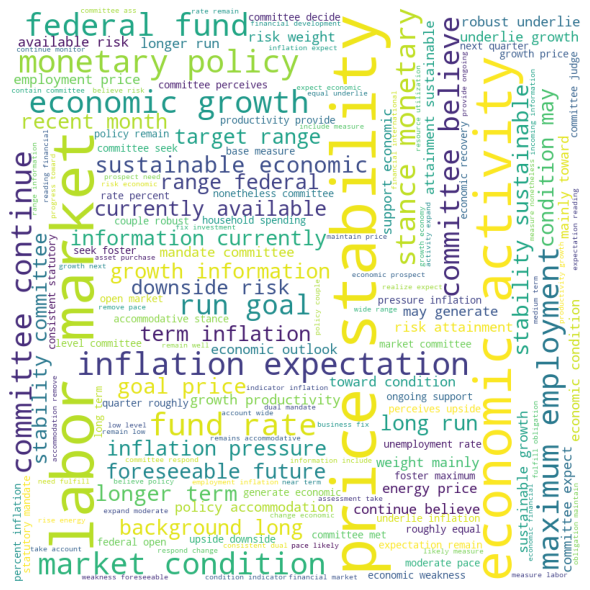

In [17]:
# Building Word Cloud for Statements - MACHINE LEARNING

from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(st_words)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

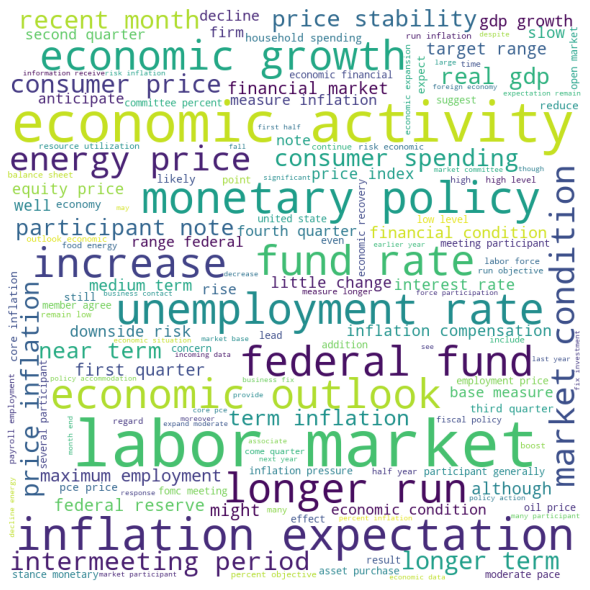

In [18]:
# Building Word Cloud for Minutes - MACHINE LEARNING
# conda install -c https://conda.anaconda.org/conda-forge wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(mins_words)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

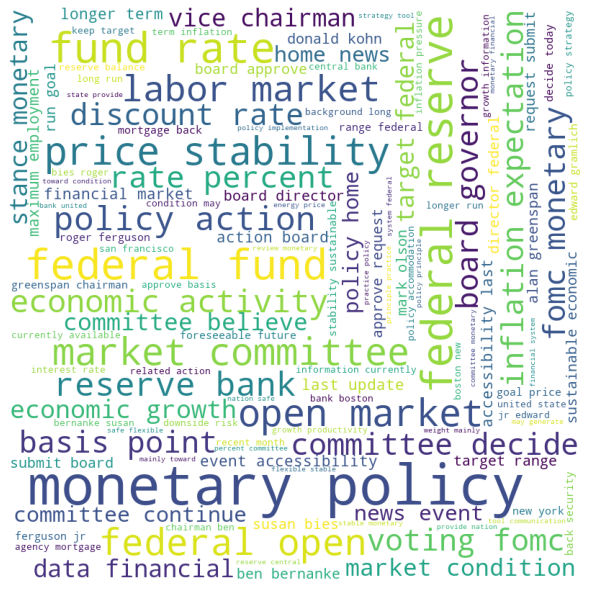

In [19]:
# Building Word Cloud for Statements - DICTIONARY-BASED METHOD

from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(st_words_db)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

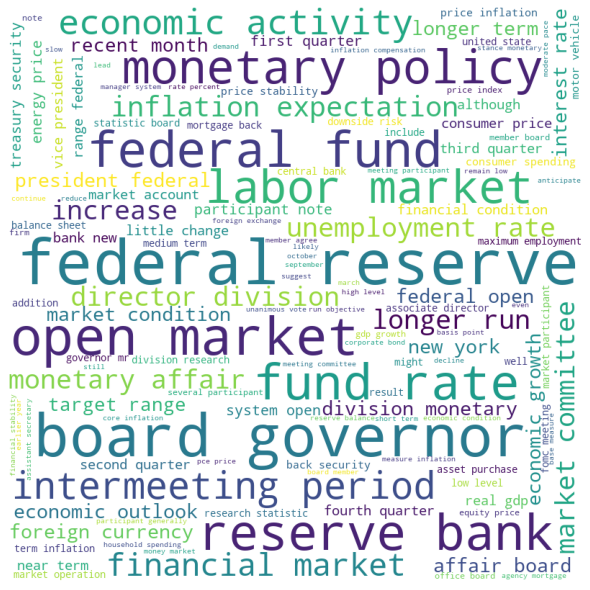

In [20]:
# Building Word Cloud for Minutes - DICTIONARY-BASED METHOD

from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(mins_words_db)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

In [21]:
# SAVE DF AS PICKLE FOR DICTIONARY-BASED MODEL

st_df.to_pickle('../data/FOMC/st_df.pickle')
mins_df.to_pickle('../data/FOMC/mins_df.pickle')